# Feature Abstraction 

## Historical Averaging

### Naïve Methods

The main way to predict the outcome of a tennis match is to use historical averaging.

A very simplistic model that could be used would be this one:
$$
\text{Probability of winning a match} = \frac{\text{Matches won}}{\text{Matches played}}
$$

We can try that method using Federer.

In [108]:
# Init
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr, when, lit, sum, avg, max

spark = SparkSession \
        .builder \
        .appName("Python Spark SQL basic example") \
        .config("spark.some.config.option", "some-value") \
        .getOrCreate()

def init_df(): 
    return spark.read \
        .csv("./dataset/all_matches.csv", header=True)

In [109]:
# Federer average
df = init_df()

df = df.select(["player_id", "player_victory", "return_points_won", "return_points_attempted", "aces", 'first_serve_attempted']) \
    .where(df['player_id'] == 'roger-federer') \
    .dropna() \
    .withColumn("player_victory", \
        when(df["player_victory"] == 't', 1).otherwise(0)) \
    .withColumn('wrp', df["return_points_won"] / df["return_points_attempted"]) \
    .withColumn('aces_p', df['aces'] / df['first_serve_attempted']) \
    .groupBy(['player_id']) \
    .agg(avg('player_victory').alias('winrate'),
        avg('wrp').alias('wrp'),
        avg('aces_p').alias('aces_p'))

df.select(['player_id', 'winrate', 'wrp', 'aces_p']) \
    .show()

+-------------+-----------------+-------------------+-------------------+
|    player_id|          winrate|                wrp|             aces_p|
+-------------+-----------------+-------------------+-------------------+
|roger-federer|0.821483771251932|0.40581951098005054|0.10317008615061739|
+-------------+-----------------+-------------------+-------------------+



Unfortunately, the 82% winrate we get for Federer isn't very useful for predicting a single given match as it doesn't take the opposing player into account. If Federer is playing against a top player such as  Nadal, the winrate should be much lower, whereas if Federer were playing against a bad player, the winrate should be much higher.

### Player/Opponent Average

A simple but naïve way to fix our oginial problem is to group the winrate for each player.

- Winrate: The raw probably to win a match against the opponent.
- WSP: Win on Serve Probability. Probability to win a point when the player is the one serving. 
- WRP: Win on Return Probability. Probability to win a point when the opponent is the one serving.
- Aces P: Probability for any given serve to be an ace.

In [112]:
# Federer average vs. Opponents

def winrate(player, opponents):
    df = init_df()
    
    df = df.select(["player_id", "opponent_id", "player_victory", "service_points_won", "service_points_attempted", "return_points_won", "return_points_attempted", "aces"]) \
    .where(df['player_id'] == player) \
    .where(df['opponent_id'].isin(opponents)) \
    .dropna() \
    .withColumn("player_victory", \
              when(df["player_victory"] == 't', 1).otherwise(0)) \
    .withColumn('wsp', df["service_points_won"] / df["service_points_attempted"]) \
    .withColumn('wrp', df["return_points_won"] / df["return_points_attempted"]) \
    .withColumn('aces_p', df['aces'] / df["service_points_attempted"]) \
    .groupBy(['player_id', 'opponent_id']) \
    .agg(avg('player_victory').alias('winrate'),
        avg('wsp').alias('wsp'),
        avg('wrp').alias('wrp'),
        avg('aces_p').alias('aces_p'))

    return df.select(['player_id', 'opponent_id', 'winrate', 'wsp', 'wrp', 'aces_p'])

opponents = ['rafael-nadal'] #, 'novak-djokovic', 'andy-murray']

winrate('roger-federer', opponents).show()

+-------------+------------+------------------+------------------+-------------------+-------------------+
|    player_id| opponent_id|           winrate|               wsp|                wrp|             aces_p|
+-------------+------------+------------------+------------------+-------------------+-------------------+
|roger-federer|rafael-nadal|0.3333333333333333|0.6164573082937798|0.35874866430031316|0.08505536786196226|
+-------------+------------+------------------+------------------+-------------------+-------------------+



While those winrates are a lot more userful, we can still do a lot better.

### Surface Weighting

One very interesting thing about tennis is the existence of different court surfaces. The most common courts are hard courts and clay courts, but there also exists grass courts and carpet courts. Different court types greatly affect the way the tennis ball bounces off the ground and the way players move accross the court, which gives distinct advantages or disadvantages to players with different playstyles.

If we take our previous winrates and group them by terrain types, we get the following:

In [58]:
# Winrate per surface
from pyspark.sql.functions import col, expr, when, lit

def winrate_per_surface(player, opponents):
    df = init_df()
    
    df = df.select(["player_id", "opponent_id", "player_victory", "court_surface", "return_points_won", "return_points_attempted"]) \
        .where(df['player_id'] == player) \
        .where(df['opponent_id'].isin(opponents)) \
        .dropna() \
        .withColumn("player_victory", \
                  when(df["player_victory"] == 't', 1).otherwise(0)) \
        .withColumn('matches', lit(1)) \
        .withColumn('wrp', df["return_points_won"] / df["return_points_attempted"]) \
        .groupBy(['player_id', 'opponent_id', 'court_surface']) \
        .sum()
    
    return df.withColumn('winrate', df['sum(player_victory)'] / df['sum(matches)']) \
        .withColumn('wrp', df['sum(wrp)'] / df['sum(matches)'])  \
        .select(['player_id', 'opponent_id', 'court_surface', 'winrate', 'wrp'])

winrate_per_surface('roger-federer', ['rafael-nadal']) \
    .sort(['opponent_id', 'court_surface']) \
    .show()

+-------------+------------+-------------+-------------------+-------------------+
|    player_id| opponent_id|court_surface|            winrate|                wrp|
+-------------+------------+-------------+-------------------+-------------------+
|roger-federer|rafael-nadal|         Clay|0.13333333333333333|0.36667200677769013|
|roger-federer|rafael-nadal|        Grass| 0.6666666666666666|0.35599818206540035|
|roger-federer|rafael-nadal|         Hard| 0.4666666666666667|0.35137541826991864|
+-------------+------------+-------------+-------------------+-------------------+



Those results are much better, but they still suffer from a very big flaw: a lack of sample. Between Federer and Nadal, we only had 33 matches to work with, and that we split those matches by court surface, we have even less matches to work.

Even more problematic is what happens if we want to predict the outcome of a match from two players who have never played against each others. Our current system simply doesn't allow us to do that. We need to find something better.

### Common Players

As discussed in the paper, Knottenbelt proposed a method for a fair evaluation of two players by using their common opponents. This works by finding the set of common opponents between two players, finding the performance of the players with each common opponents, and the naveraging the performances accross all common opponents.

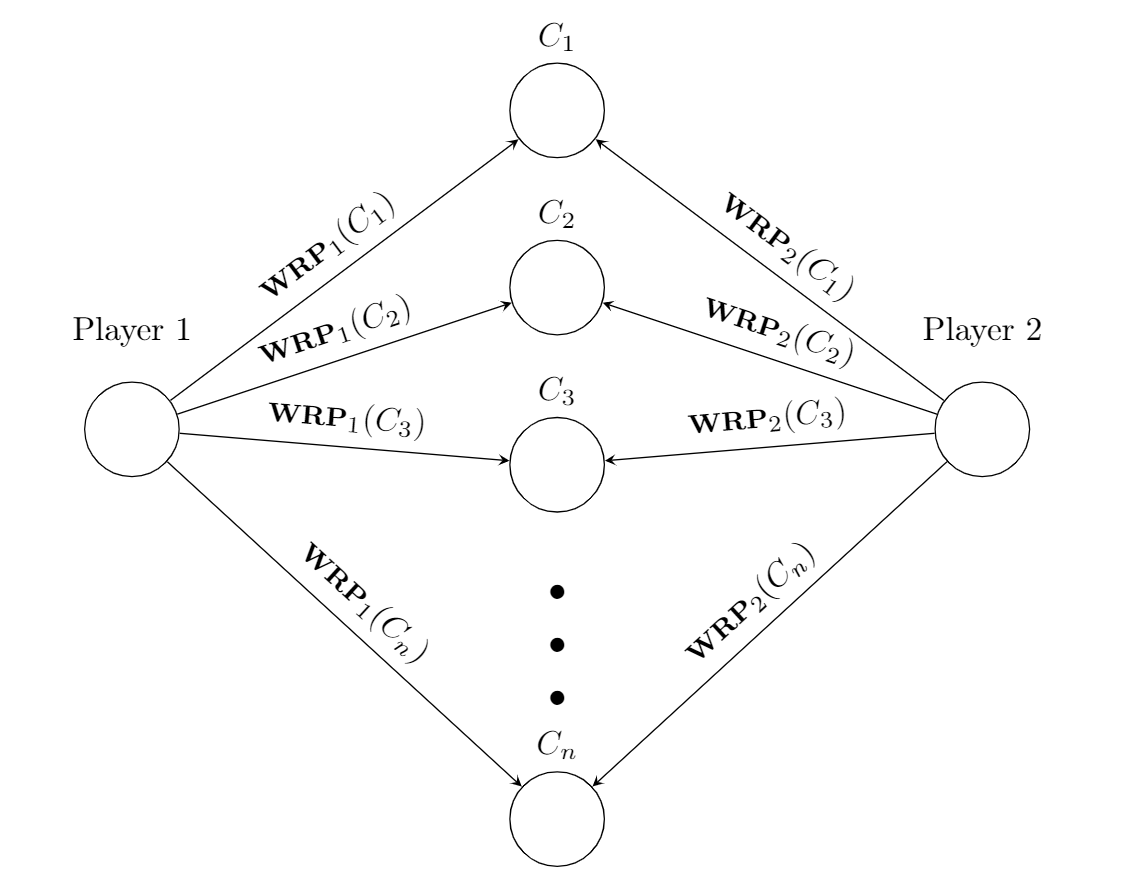

$$
\textbf{WRP}_i = \frac{\sum^{n}_{j=0}{\textbf{WRP}_i(C_j)}}{n} 
$$

$$
\textbf{WRP} = \textbf{WRP}_1 - \textbf{WRP}_2
$$


In [110]:
def common_opponents(p1, p2):
    df = init_df()
    
    return df.select(['player_id', 'opponent_id']) \
        .where(df['player_id'].isin([p1, p2])) \
        .rdd \
        .map(lambda x: (
            x['opponent_id'], (
                1 if x['player_id'] == p1 else 0, 
                1 if x['player_id'] == p2 else 0)
            )
        ) \
        .reduceByKey(lambda a, b: (
            1 if (a[0] == 1 or b[0] == 1) else 0,
            1 if (a[0] == 1 or b[0] == 1) else 0)
        ) \
        .filter(lambda x: x[1] == (1, 1)) \
        .map(lambda x: [x[0]]) \
        .reduce(lambda a, b: a + b)

def winrate_common(player, opponent):
    c = common_opponents(player, opponent)
    print(f'Found {len(c)} common opponents between {player} and {opponent}.')

    wrp1 = winrate(player, c) \
        .groupBy() \
        .avg('wrp') \
        .withColumnRenamed('avg(wrp)', 'wrp(player)')

    wrp2 = winrate(opponent, c) \
        .groupBy() \
        .avg('wrp') \
        .withColumnRenamed('avg(wrp)', 'wrp(opponent)')
    
    wrp = wrp1.join(wrp2, how='full_outer')

    return wrp.withColumn('wrp', wrp['wrp(player)'] - wrp['wrp(opponent)']) \
        .withColumn('player_id', lit(player)) \
        .withColumn('opponent_id', lit(opponent)) \
        .select(['player_id', 'opponent_id', 'wrp(player)', 'wrp(opponent)', 'wrp'])

winrate_common('roger-federer', 'rafael-nadal').show()

Found 286 common opponents between roger-federer and rafael-nadal.
+-------------+------------+------------------+------------------+--------------------+
|    player_id| opponent_id|       wrp(player)|     wrp(opponent)|                 wrp|
+-------------+------------+------------------+------------------+--------------------+
|roger-federer|rafael-nadal|0.4191861388382374|0.4512309349815742|-0.03204479614333677|
+-------------+------------+------------------+------------------+--------------------+



In [59]:
def winrate_common_per_surface(player, opponent):
    c = common_opponents(player, opponent)
    print(f'Found {len(c)} common opponents between {player} and {opponent}.')

    wrp1 = winrate_per_surface(player, c) \
        .groupBy('court_surface') \
        .avg('wrp') \
        .withColumnRenamed('avg(wrp)', 'wrp(player)')
    
    wrp2 = winrate_per_surface(opponent, c) \
        .groupBy('court_surface') \
        .avg('wrp')  \
        .withColumnRenamed('avg(wrp)', 'wrp(opponent)')
    
    wrp = wrp1.join(wrp2, on="court_surface")
    return wrp.withColumn('wrp', wrp['wrp(player)'] - wrp['wrp(opponent)']) \
        .withColumn('player_id', lit(player)) \
        .withColumn('opponent_id', lit(opponent)) \
        .select(['player_id', 'opponent_id', 'court_surface', 'wrp(player)', 'wrp(opponent)', 'wrp']) \
    
winrate_common_per_surface('roger-federer', 'rafael-nadal') \
    .sort('court_surface') \
    .show()

Found 286 common opponents between roger-federer and rafael-nadal.
+-------------+------------+-------------+-------------------+-------------------+--------------------+
|    player_id| opponent_id|court_surface|        wrp(player)|      wrp(opponent)|                 wrp|
+-------------+------------+-------------+-------------------+-------------------+--------------------+
|roger-federer|rafael-nadal|       Carpet| 0.4014252995689409|0.28446601941747574| 0.11695928015146517|
|roger-federer|rafael-nadal|         Clay|0.41825276437812303| 0.4919234895661907|-0.07367072518806767|
|roger-federer|rafael-nadal|        Grass| 0.4030403570202655| 0.3921145679717292|0.010925789048536305|
|roger-federer|rafael-nadal|         Hard|0.41785422193759286| 0.4292361752655692|-0.01138195332797...|
+-------------+------------+-------------+-------------------+-------------------+--------------------+



### Time Discounting

Maybe